In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms 
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:


print(torch.__version__)
print(torchvision.__version__)


1.13.0+cu117
0.14.0+cu117


In [3]:
import os
folder_path = 'C:/Users/siddu/SU22_project/cursive_prediction/datafileszipped/datafiles'
os.chdir(folder_path)
files_in_folder = os.listdir()

In [4]:
file_dic = {}
for file in files_in_folder:
    letter = file[-5]
    file_dic[file] = letter

In [5]:
df = pd.DataFrame(list(file_dic.items()), columns=['file_name', 'letter'])

In [6]:
df

,file_name,letter
0,0000_a.png,a
1,0001_b.png,b
2,0002_n.png,n
3,0003_o.png,o
4,0004_e.png,e
...,...,...
1935,1935_i.png,i
1936,1936_x.png,x
1937,1937_o.png,o
1938,1938_l.png,l


In [7]:

IMG_SIZE = 64
BATCH_SIZE = 32

In [8]:
from PIL import Image

def png_to_tensor(path):
    # Replace 'path_to_image.png' with the actual path to your PNG file
    image_path = folder_path + '/' + path

    # Open the image
    image = Image.open(image_path)
    bw_image = image.convert('L')
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)
    img_tensor = data_transform(bw_image)


    return img_tensor

In [9]:
# FUNCTION TO ADD NOISE 
def add_gaussian_noise(tensor, mean=0.0, std=0.1):
    noise = torch.randn(tensor.size()) * std + mean
    noisy_tensor = tensor + noise
    return torch.clamp(noisy_tensor, min=-1.0, max=1.0)

In [10]:
# IMAGE TO NOISY TENSOR
def png_to_noisy_tensor(path, noise_mean=0.0, noise_std=0.1):
    # Replace 'path_to_image.png' with the actual path to your PNG file
    image_path = folder_path + '/' + path

    # Open the image
    image = Image.open(image_path)
    bw_image = image.convert('L')
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)
    img_tensor = data_transform(bw_image)

    # Add Gaussian noise to the tensor
    noisy_img_tensor = add_gaussian_noise(img_tensor, mean=noise_mean, std=noise_std)

    return noisy_img_tensor


In [11]:
def show_tensor_image(tensor):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
    return reverse_transforms(tensor)

In [12]:
df2 = df.copy()

In [13]:
df2

,file_name,letter
0,0000_a.png,a
1,0001_b.png,b
2,0002_n.png,n
3,0003_o.png,o
4,0004_e.png,e
...,...,...
1935,1935_i.png,i
1936,1936_x.png,x
1937,1937_o.png,o
1938,1938_l.png,l


In [14]:
df['image'] = df['file_name'].apply(png_to_tensor)
df.drop(columns = ['file_name'], inplace = True)
df = df[['image', 'letter']]

In [15]:
df['image'][0]

tensor([[[0.5608, 0.5843, 0.6627,  ..., 0.6784, 0.6392, 0.5922],
         [0.5373, 0.5843, 0.6549,  ..., 0.6706, 0.6392, 0.6000],
         [0.4980, 0.5529, 0.6078,  ..., 0.6471, 0.6235, 0.6000],
         ...,
         [0.7333, 0.7255, 0.7020,  ..., 0.7333, 0.7647, 0.7725],
         [0.7176, 0.7255, 0.7176,  ..., 0.7412, 0.7647, 0.7725],
         [0.7176, 0.7255, 0.7255,  ..., 0.7412, 0.7647, 0.7725]]])

In [16]:
df['image'][0]

tensor([[[0.5608, 0.5843, 0.6627,  ..., 0.6784, 0.6392, 0.5922],
         [0.5373, 0.5843, 0.6549,  ..., 0.6706, 0.6392, 0.6000],
         [0.4980, 0.5529, 0.6078,  ..., 0.6471, 0.6235, 0.6000],
         ...,
         [0.7333, 0.7255, 0.7020,  ..., 0.7333, 0.7647, 0.7725],
         [0.7176, 0.7255, 0.7176,  ..., 0.7412, 0.7647, 0.7725],
         [0.7176, 0.7255, 0.7255,  ..., 0.7412, 0.7647, 0.7725]]])

In [17]:
for i in range(10):
    noise_df = df2.copy()
    noise_df['image'] = noise_df['file_name'].apply(png_to_noisy_tensor)
    noise_df.drop(columns = ['file_name'], inplace = True)
    noise_df = noise_df[['image', 'letter']]    
    df = df.append(noise_df, ignore_index= True)


In [18]:
import torch
from torch.utils.data import Dataset, DataLoader


# df to tuples
data_tuples = list(zip(df['image'].tolist(), df['letter'].tolist()))

# Split indices
dataset_size = len(data_tuples)
indices = list(range(dataset_size))
split = int(0.2 * dataset_size)

torch.manual_seed(42)

# Shuffle indices
indices_shuffled = torch.randperm(len(indices))

# Split 
train_indices, test_indices = indices_shuffled[split:], indices_shuffled[:split]

# custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        image_tensor, letter = self.data[index]
        return image_tensor, ord(letter) - ord('a')

    def __len__(self):
        return len(self.data)

# custom Datasets
train_dataset = CustomDataset(data=[data_tuples[i] for i in train_indices])
test_dataset = CustomDataset(data=[data_tuples[i] for i in test_indices])

#  DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [19]:
for X_batch, y_batch in test_loader:
    print("X batch:", X_batch)
    print("y batch:", y_batch)
    break  

X batch: tensor([[[[0.9920, 0.8618, 0.8936,  ..., 0.9124, 1.0000, 0.8647],
          [0.8649, 1.0000, 0.8967,  ..., 1.0000, 1.0000, 0.9845],
          [1.0000, 0.9862, 1.0000,  ..., 0.8917, 0.9107, 0.7749],
          ...,
          [0.8898, 1.0000, 0.9452,  ..., 0.8701, 0.8830, 0.8917],
          [1.0000, 0.9821, 1.0000,  ..., 0.7221, 0.9122, 0.8981],
          [0.7282, 0.8308, 0.9136,  ..., 0.8818, 0.9985, 1.0000]]],


        [[[0.9079, 0.8628, 0.7311,  ..., 1.0000, 1.0000, 0.9229],
          [0.9372, 1.0000, 1.0000,  ..., 1.0000, 0.8420, 1.0000],
          [0.9896, 0.8820, 1.0000,  ..., 0.9811, 0.8990, 0.9220],
          ...,
          [0.9321, 0.9100, 0.8139,  ..., 0.7332, 0.9023, 0.7061],
          [1.0000, 0.8448, 0.9104,  ..., 0.7805, 0.8332, 0.9980],
          [0.9145, 1.0000, 0.8948,  ..., 0.9236, 1.0000, 1.0000]]],


        [[[0.4941, 0.8042, 0.7008,  ..., 0.7046, 0.7213, 0.7000],
          [0.4630, 0.4232, 0.4215,  ..., 0.6646, 0.6715, 0.7116],
          [0.5198, 0.6364, 0.

In [20]:
len(train_loader)

534

In [21]:
# AlexNet architecture
class AlexNet(nn.Module):
    def __init__(self, num_classes=26):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [22]:
# Instantiate the model
alexnet = AlexNet().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.01, momentum=0.9)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        
        labels = torch.tensor(labels, dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

print("Training Finished")


C:\Users\siddu\AppData\Local\Temp\ipykernel_15508\2453823309.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch 1, Loss: 2.763547610477562
Epoch 2, Loss: 1.5188484206963122
Epoch 3, Loss: 0.5341495398697111
Epoch 4, Loss: 0.28531629010452453
Epoch 5, Loss: 0.15577447173915532
Epoch 6, Loss: 0.10665389693347381
Epoch 7, Loss: 0.10711046971034299
Epoch 8, Loss: 0.04698897054397966
Epoch 9, Loss: 0.06163578690383941
Epoch 10, Loss: 0.019740690448519473
Training Finished


In [23]:

test_loss = 0.0

alexnet.eval()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = torch.tensor(labels, dtype=torch.long).to(device)

        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

    print(f"Test Loss: {test_loss/len(test_loader)}")

print("Testing Finished")


C:\Users\siddu\AppData\Local\Temp\ipykernel_15508\3622266950.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Test Loss: 0.018601914496087633
Testing Finished


In [24]:
for i, (inputs, labels) in enumerate(train_loader):
    x = inputs
    y = labels
    break

In [25]:
x = x[0]
x

tensor([[[ 9.8357e-01,  9.1988e-01,  9.3131e-01,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 8.6466e-01,  8.1068e-01,  8.5065e-01,  ...,  8.6495e-01,
           8.9474e-01,  9.6549e-01],
         [ 6.9174e-01,  6.7081e-01,  1.0000e+00,  ...,  9.2094e-01,
           9.9560e-01,  7.6849e-01],
         ...,
         [ 7.1836e-01,  6.1316e-01,  8.1793e-01,  ...,  1.4899e-01,
          -7.8275e-02,  1.1268e-01],
         [ 9.3123e-01,  8.8014e-01,  6.8307e-01,  ..., -7.8497e-04,
          -3.1421e-02,  3.3042e-02],
         [ 8.8881e-01,  6.9963e-01,  9.1540e-01,  ...,  5.0580e-01,
           6.6258e-01,  7.3611e-01]]])

In [26]:
single_input_reshaped = np.expand_dims(x, axis=0)


In [28]:
def pred(image_tensor):
    # Ensure the input tensor is on the same device as the model
    image_tensor = image_tensor.to(device)

    # Perform the forward pass
    with torch.no_grad():
        output = alexnet(image_tensor)

    return output

In [29]:
pred(x)[0].argmax()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x36 and 9216x4096)

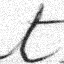

In [ ]:
show_tensor_image(x[0])